In [1]:
#from mpl_toolkits.basemap import Basemap
import numpy as np
import utm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import linecache
import my_functions as mf
from scipy.ndimage import gaussian_filter

In [2]:
%matplotlib inline

In [3]:
file = '/home/flora/Documents/FLORA/interpolation_misc/inv_datasynt05_NLCG_063.rho'

### Open model1 - modem 

In [4]:
ld=linecache.getline(file, 2)
lx=linecache.getline(file, 3)
ly=linecache.getline(file, 4)
lz=linecache.getline(file, 5)
dim=ld.split()
nx=int(dim[0])
ny=int(dim[1])
nz=int(dim[2])
#vecteur de taille de maille
hx=np.hstack(float(lx.split()[i]) for i in np.arange(nx) )
hy=np.hstack(float(ly.split()[i]) for i in np.arange(ny) )
hz=np.hstack(float(lz.split()[i]) for i in np.arange(nz) )

#model values
ind=7
rho = np.zeros((nx,ny,nz))

for k in range(nz):
    for j in range(ny):
        l=linecache.getline(file, ind)
        rho[:,j,k]=np.hstack(float(l.split()[i]) for i in np.arange(nx) )[::-1]
        ind = ind+1        
    ind = ind+1

use coordinates

In [5]:
refE,refN,zone,l = utm.from_latlon(-23.965, -69.475)

#Position centre des mailes (utm & lat/lon)
ctx=np.ones(len(hx))
for i in np.arange(len(hx)):
    ctx[i]=(sum(hx[0:i])+sum(hx[0:i+1]))/2+refN
    
cty=np.ones(len(hy))
for i in np.arange(len(hy)):
    cty[i]=(sum(hy[0:i])+sum(hy[0:i+1]))/2+refE

ctz=np.ones(len(hz))
for i in np.arange(len(hz)):
    ctz[i]=(sum(hz[0:i])+sum(hz[0:i+1]))/2

#ctz = ctz*(-1)

Xla=np.zeros(len(ctx))
Ylon=np.zeros(len(cty))

for j in range(len(cty)):
    for i in range(len(ctx)):
        U=utm.to_latlon(cty[j],ctx[i],zone,l)
        Xla[i]=U[0]
        Ylon[j]=U[1]
        

#mlg,mla=np.meshgrid(Ylon,Xla)
#mx,my = np.meshgrid(cty,ctx)

#mx1,my1 = np.meshgrid(ctz,Ylon)

### Select area from model

In [10]:
#north
xmin = 7515000.
xmax = 7524000.
#east
ymin = 618000.
ymax = 634000.

zmin = 0.
zmax = 3000.

# #east
# xmin = -22.48
# xmax = -22.35
# #north
# ymin = -67.85
# ymax = -67.70

# zmin = 0.
# zmax = 5000.

In [11]:
x1,y1,z1,x,y,z,rho_n = mf.select_area(xmin,xmax,ymin,ymax,zmin,zmax,ctx,cty,ctz,rho)

In [12]:
print(rho_n.shape)

(19, 35, 42)


In [13]:
print(rho.shape)

(54, 69, 80)


In [14]:
mx,my = np.meshgrid(y,x)
mx1,my1 = np.meshgrid(z,y)

In [15]:
# import MT stations coordinates
path = '/home/flora/Documents/FLORA/interpolation_misc/coord'
data = np.loadtxt(path,dtype='float',usecols=(0,1,2))

stn = data[:,0]
lat = data[:,1]
lon = data[:,2]

Xla=np.zeros(len(lat))
Ylon=np.zeros(len(lon))
for j in range(len(lat)):
    for i in range(len(lon)):
        U=utm.from_latlon(lat[j],lon[i],zone)
        Xla[i]=U[0]
        Ylon[j]=U[1]



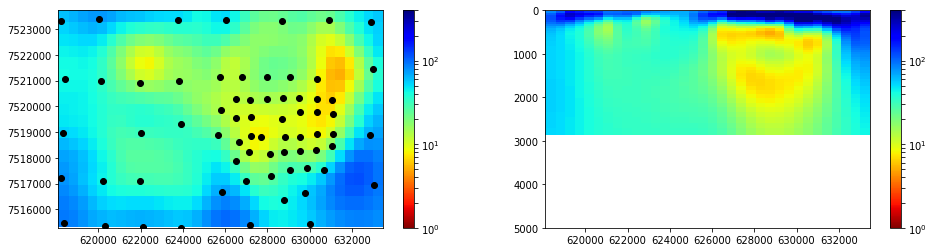

In [16]:
cmap = plt.cm.jet
cmap_r = mf.reverse_colourmap(cmap)

model = (np.e**rho_n) 
z_plot = np.argmin(np.abs(z-1250))
x_plot = np.argmin(np.abs(x-7519000))

plt.figure(figsize=(16,4))

plt.subplot(1,2,1)
plt.pcolor(mx,my,model[:,:,z_plot],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.plot(Xla,Ylon,'ko')
plt.colorbar()

plt.subplot(1,2,2)
plt.pcolor(my1,mx1,model[x_plot,:,:],cmap=cmap_r,norm = LogNorm(vmin=1, vmax=400))
plt.ylim(5000,0)
plt.colorbar()
plt.show()

### Interpolation 

In [17]:
# Control points

xc = np.copy(x1)+10
yc = np.copy(y1)+10
zc = np.copy(z1)+10

ln = xc.size

In [18]:
print(xc.size,yc.size,zc.size)

27930 27930 27930


In [19]:
print(x1.size,y1.size,z1.size)

27930 27930 27930


In [20]:
#Interpolation points

# dx1 = (x[1:]+x[:-1])/2
# dy1 = (y[1:]+y[:-1])/2
# #dz = (z[1:]+z[:-1])/2
# dz1 = z+20

# dx = np.hstack(([x[0],dx1,x[-1]]))
# dy = np.hstack(([y[0],dy1,y[-1]]))
# dz = np.hstack(([z[0],dz1,z[-1]]))

# x0n = len(dx1)
# y0n = len(dy1)
# z0n = len(dz1)

# X0,Y0,Z0 = np.meshgrid(dx1,dy1,dz1)
# x0 = np.ravel(X0)
# y0 = np.ravel(Y0)
# z0 = np.ravel(Z0)

x0 = np.copy(x1)
y0 = np.copy(y1)
z0 = np.copy(z1)

In [21]:
# Calculate interpolation function
t = 0.9
A = mf.calc_A_by_column(x1,y1,z1,xc,yc,zc,1,t)
model_n = np.ravel(model)
            

In [22]:
H = np.dot(A.T,A)

In [23]:
h0 = np.trace(H)/ln

In [24]:
mu = 1E-12*h0
print(mu)

2.7925910371307602e-08


In [25]:
p = np.linalg.solve(H+(mu*np.identity(ln)),np.dot(A.T,model_n))

In [26]:
# Interpolate funtion rho in points x0, y0, z0

A0 = mf.calc_A_by_column(x0,y0,z0,xc,yc,zc,1,t)

In [27]:
# Interpolated matrix
rho0 = np.dot(A0,p)
rho0_m = rho0.reshape((rho_n.shape))

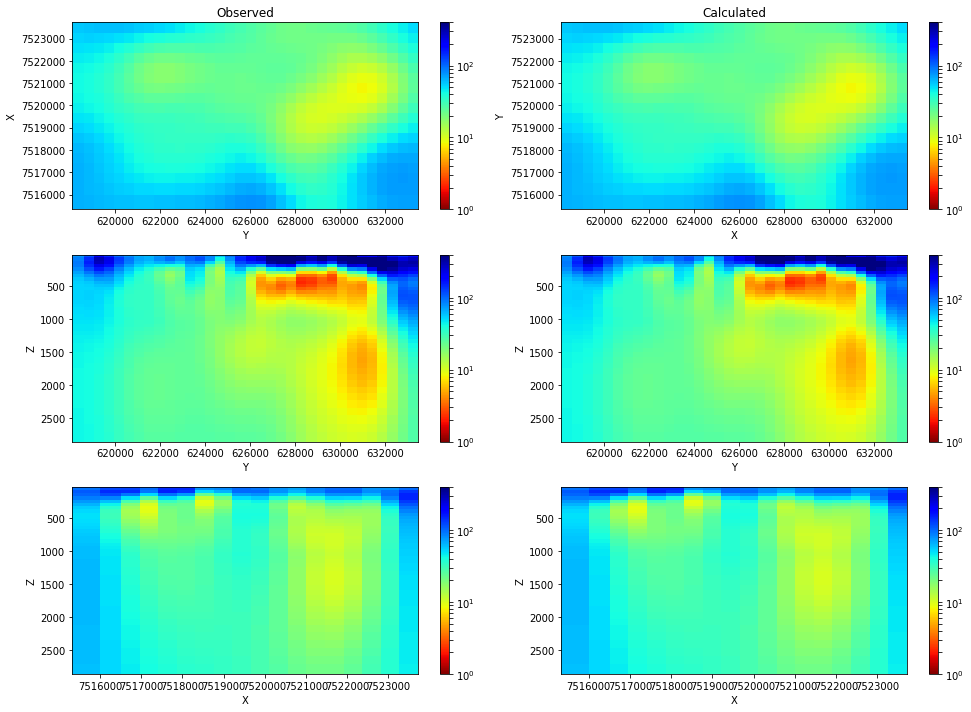

In [28]:
mf.plot_models_6sub(7520000,622500,2500,x,y,z,x,y,z,model,rho0_m)